## AC209b / CS109b Final Project - Milestone 1
Yujiao Chen, Brian Ho, Jonathan Jay
| 04/05/2017


The notebook to submit for this milestone needs to at least include:
- API code to access the genre and movie poster path of your favorite movie
- Genre for this movie listed by TMDb and IMDb
- A list of the 10 most popular movies of 2016 from TMDb and their genre obtained via the API
- Comments on what challenges you see for predicting movie genre based on the data you have, and how to address them
- Code to generate the movie genre pairs and a suitable visualization of the result
- Additional visualization sketches and EDA with a focus on movie genres
- A list of questions you could answer with this and related data. Get creative here!

In [ ]:
import imdb
import httplib
import json
import requests
import pandas as pd
import numpy as np
import time
import wget
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import metrics
from IPython.display import IFrame
from sklearn.decomposition import PCA
%matplotlib inline

In [17]:
### Get a list of genre ids and genre names from TMDB API
# N.B. this is a quick query of the API; a more complete pull is made later in notebook
conn = httplib.HTTPSConnection("api.themoviedb.org")
payload = "{}"
conn.request("GET", "/3/genre/movie/list?language=en-US&api_key=f36152ef9bcf77f762135508f9f4e705", payload)

res = conn.getresponse()
data = res.read()
data=json.loads(data)
genres_list = data["genres"]

genres_list

[{u'id': 28, u'name': u'Action'},
 {u'id': 12, u'name': u'Adventure'},
 {u'id': 16, u'name': u'Animation'},
 {u'id': 35, u'name': u'Comedy'},
 {u'id': 80, u'name': u'Crime'},
 {u'id': 99, u'name': u'Documentary'},
 {u'id': 18, u'name': u'Drama'},
 {u'id': 10751, u'name': u'Family'},
 {u'id': 14, u'name': u'Fantasy'},
 {u'id': 36, u'name': u'History'},
 {u'id': 27, u'name': u'Horror'},
 {u'id': 10402, u'name': u'Music'},
 {u'id': 9648, u'name': u'Mystery'},
 {u'id': 10749, u'name': u'Romance'},
 {u'id': 878, u'name': u'Science Fiction'},
 {u'id': 10770, u'name': u'TV Movie'},
 {u'id': 53, u'name': u'Thriller'},
 {u'id': 10752, u'name': u'War'},
 {u'id': 37, u'name': u'Western'}]

In [25]:
### Search for you favorite movie in TMDB and get the genres & poster path
conn = httplib.HTTPSConnection("api.themoviedb.org")
payload = "{}"
conn.request("GET", "/3/search/movie?query=forrest%20gump&api_key=f36152ef9bcf77f762135508f9f4e705", payload)

res = conn.getresponse()
data = res.read()
data=json.loads(data)

genre_id = data["results"][0]["genre_ids"]
poster_path = data["results"][0]["poster_path"]

### From genre id to genre names
movie_genre=[]
for i in genre_id:
    for genre in genres_list:
        if genre["id"]==i:
            movie_genre.append(genre["name"])
movie_genre

[u'Comedy', u'Drama', u'Romance']

In [26]:
### download poster
url = "https://image.tmdb.org/t/p/w500"
url = url + poster_path

wget.download(url,"Favorite movie poster.jpg")

'poster_test (1).jpg'

In [8]:
### Search the favorite movie in IMDB and get the genres information
i = imdb.IMDb()
movie_list = i.search_movie("Forrest Gump")
first_match = movie_list[0]
i.update(first_match)
first_match["genres"]

[u'Comedy', u'Drama', u'Romance']

In [9]:
### A list of the 10 most popular movies of 2016 from TMDB and their genres
conn = httplib.HTTPSConnection("api.themoviedb.org")
payload = "{}"
conn.request("GET", "/3/discover/movie?year=2016&page=1&include_video=false&include_adult=false&sort_by=popularity.desc&language=en-US&api_key=f36152ef9bcf77f762135508f9f4e705", payload)
res = conn.getresponse()
data = res.read()
data=json.loads(data)
movies = data["results"][0:10]

movie_dict = {}

for movie in movies:
    movie_genre=[]
    for i in movie["genre_ids"]:
        for genre in genres_list:
            if genre["id"]==i:
                movie_genre.append(genre["name"])
    movie_dict[movie["original_title"]]=movie_genre

movie_dict

{u'Arrival': [u'Drama', u'Science Fiction'],
 u'Captain America: Civil War': [u'Action', u'Science Fiction'],
 u'Deadpool': [u'Action', u'Adventure', u'Comedy', u'Romance'],
 u'Doctor Strange': [u'Action', u'Adventure', u'Fantasy', u'Science Fiction'],
 u'Fantastic Beasts and Where to Find Them': [u'Adventure',
  u'Action',
  u'Fantasy'],
 u'Finding Dory': [u'Adventure', u'Animation', u'Comedy', u'Family'],
 u'John Wick': [u'Action', u'Thriller'],
 u'Rogue One: A Star Wars Story': [u'Action',
  u'Drama',
  u'Science Fiction',
  u'War'],
 u'Sing': [u'Animation', u'Comedy', u'Drama', u'Family', u'Music'],
 u'Split': [u'Horror', u'Thriller']}

In [27]:
### Generating a heatmap to show the frequency of genres appearing together
g_names = []
for i in genres_list:
    g_names.append(i["name"])
    
g_matrix = np.zeros(shape=(19,19))
g_matrix = pd.DataFrame(g_matrix, index=g_names, columns=g_names)

In [28]:
### Using most popular movie data
conn = httplib.HTTPSConnection("api.themoviedb.org")
payload = "{}"
conn.request("GET", "/3/discover/movie?include_video=false&include_adult=false&sort_by=popularity.desc&language=en-US&api_key=f36152ef9bcf77f762135508f9f4e705", payload)
res = conn.getresponse()
data = res.read()
data=json.loads(data)

movies = data["results"]
movie_dict = {}
for movie in movies:
    movie_genre=[]
    for i in movie["genre_ids"]:
        for genre in genres_list:
            if genre["id"]==i:
                movie_genre.append(genre["name"])
    movie_dict[movie["original_title"]]=movie_genre

for movie in movie_dict:
    for i in movie_dict[movie]:
        for j in movie_dict[movie]:
            g_matrix[i][j]+=1

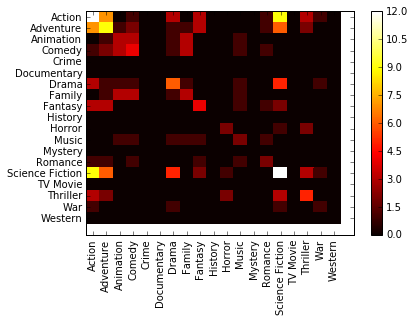

In [33]:
### Visualization of genre pairing frequencies within top 10 movies
fig,ax=plt.subplots()
heatmap=ax.pcolor(g_matrix, cmap="hot")

cbar = plt.colorbar(heatmap)

ax.set_xticks(np.arange(19) + 0.5, minor=False)
ax.set_yticks(np.arange(19) + 0.5, minor=False)
ax.invert_yaxis()

column_labels = g_names
row_labels = g_names
ax.set_xticklabels(column_labels,rotation="vertical", minor=False)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

In [50]:
### Further exploration on a large data set pulled from TMDB
# loops through all years from 2006 to 2017 and get 1000 most popular movies in each year
years = range(2006,2016)

for year in years:
    
    '''
    # intial API request to get
    payload = {'api_key': '9290a6fe9125b32e7bbe5512036be0d0',
           'sort_by':'popularity.desc',
           'primary_release_date.gte':year,
           'primary_release_date.lte':year+1,
               'page': 1}

    r = requests.get('https://api.themoviedb.org/3/discover/movie?', params=payload)
    
    print 'For ', year, ' there are ', r.json()['total_results'], ' total results across ', r.json()['total_pages'], ' total pages.'

    tmdb_movies = pd.concat([tmdb_movies, pd.io.json.json_normalize(r.json()['results'])])
    '''
    
    for page in range(1, 51):
            start = time.time()
            payload = {'api_key': '9290a6fe9125b32e7bbe5512036be0d0',
                       'sort_by':'popularity.desc',
                       'primary_release_date.gte':year,
                       'primary_release_date.lte':year+1,
                       'page': page}
            
            r = requests.get('https://api.themoviedb.org/3/discover/movie?', params=payload)
            
            if page == 1:
                print 'For ', year, ' there are ', r.json()['total_results'], ' total results across ', r.json()['total_pages'], ' total pages.'
                
                if year == 2006:
                    tmdb_movies = pd.io.json.json_normalize(r.json()['results'])
            
            else:
                tmdb_movies = pd.concat([tmdb_movies, pd.io.json.json_normalize(r.json()['results'])])
            
            delay = time.time()-start
            
            if delay < 0.25:
                time.sleep(0.25-delay)

tmdb_movies.head()

For  2006  there are  8760  total results across  438  total pages.
For  2007  there are  9079  total results across  454  total pages.
For  2008  there are  9660  total results across  483  total pages.
For  2009  there are  10140  total results across  507  total pages.
For  2010  there are  10350  total results across  518  total pages.
For  2011  there are  11147  total results across  558  total pages.
For  2012  there are  12015  total results across  601  total pages.
For  2013  there are  13350  total results across  668  total pages.
For  2014  there are  13598  total results across  680  total pages.
For  2015  there are  12365  total results across  619  total pages.


,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,False,/hdHgIcljPHli4xaJGt0INz8Gn3J.jpg,"[12, 14, 28]",58,en,Pirates of the Caribbean: Dead Man's Chest,Captain Jack Sparrow works his way out of a bl...,9.561772,/waFr5RVKaQ9dzOt3nQuIVB1FiPu.jpg,2006-06-20,Pirates of the Caribbean: Dead Man's Chest,False,6.9,3801
1,False,/xq6hXdBpDPIXWjtmvbFmtLvBFJt.jpg,"[12, 28, 53]",36557,en,Casino Royale,"Le Chiffre, a banker to the world's terrorists...",5.422289,/zlWBxz2pTA9p45kUTrI8AQiKrHm.jpg,2006-11-14,Casino Royale,False,7.2,3202
2,False,/lxNCa4FifUuLeUkWUQl2yuf9JnJ.jpg,"[16, 10751, 35, 12]",950,en,Ice Age: The Meltdown,"Diego, Manny and Sid return in this sequel to ...",5.223670,/isRuztu5Ch7FJdtSBLcG8QSOpEI.jpg,2006-03-23,Ice Age: The Meltdown,False,6.4,2152
3,False,/c5o7FN2vzI7xlU6IF1y64mgcH9E.jpg,"[18, 9648, 53]",1124,en,The Prestige,A mysterious story of two magicians whose inte...,5.176274,/5MXyQfz8xUP3dIFPTubhTsbFY6N.jpg,2006-10-19,The Prestige,False,7.9,3195
4,False,/a1MlbLBk5Sy6YvMbSuKfwGlDVlb.jpg,"[16, 12, 35, 10751]",920,en,Cars,"Lightning McQueen, a hotshot rookie race car d...",5.109242,/5damnMcRFKSjhCirgX3CMa88MBj.jpg,2006-06-08,Cars,False,6.5,2725


In [51]:
# Save results to CSV
tmdb_movies.to_csv('Top 10000 movies.csv', encoding='utf8')

RStudio was used to match the list of movies with genre names. See *"milestone01_yujiaochen_brianho_jonjay_clean_EDA.Rmd"* for information.

In [52]:
# Load PDFs generated from R into notebook
IFrame("milestone01_yujiaochen_brianho_jonjay_EDA.pdf", width=850, height=1100)

In [74]:
movies = pd.read_csv("Top 10000 movies genre counts.csv", index_col=0)
movies = movies.dropna(axis=0)

In [2]:
db = cluster.DBSCAN(eps=0.3, min_samples=10).fit(movies.iloc[:,2:])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(movies.iloc[:,2:], labels))

NameError: name 'cluster' is not defined

In [99]:
pca = PCA(n_components=2)
pca.fit(movies.iloc[:,2:])

X_pca = pca.fit_transform(movies.iloc[:,2:])

In [1]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
    else:
        class_member_mask = (labels == k)

        xy = movies.iloc[:,2:][class_member_mask & core_samples_mask]
        plt.plot(X_pca[:, 0], X_pca[:, 1], 'o', color=col, markersize=4)

        xy = movies.iloc[:,2:][class_member_mask & ~core_samples_mask]
        plt.plot(X_pca[:, 0], X_pca[:, 1], 'o', color=col, markersize=1)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

NameError: name 'labels' is not defined

###### Comments on what challenges you see for predicting movie genre based on the data you have, and how to address them

Main challenge: multiple genre assignments

Not only are there 20 possible genre assignments in TMDb--a large number of classes to predict--but movies are commonly assigned more than one genre. This suggests that genres are properties of movies, and not necessarily mutually exclusive categories. At the same time, we perceive that movies can generally be grouped according to likeness. One of our initial ideas, therefore, is to consider how movies cluster based on genre assignment alone. The idea of similarity/dissimilarity across movies could potentially be captured by distance among genre groupings, e.g. in principal components space. This analysis could potentially generate alternative outcome values for our predictions, addressing the multiple values problem described above while capturing something intuitively true about the movie (e.g. the difference between a typical comedy and a "romantic comedy").      

Some other possible solutions would be to narrow down the genres we try to predict; to sample only movies that have been assigned one genre; to create multiple entries for movies with multiple genres, assigning one genre per entry; or to develop a method for choosing a single genre among those assigned to a given movie. The correct choice among these strategies will depend partly on choices we make later about the research questions and predictor data that interest us most.

###### A list of questions you could answer with this and related data. Get creative here!

Some that we've discussed:
Can movie posters predict the year of a movie's release? What attributes of a poster are most associated with year of release?
How do prediction algorithms trained on English-language movies perform on movies in other languages?
What could an algorithm, trained to predict popularity based on movie posters, teach us if we inputted fake or modified posters? What sorts of posters would it generate, synthesizing what it has learned about popular/unpopular movies? 
